In [1]:
# To find out where the pyspark
import findspark
findspark.init()

In [2]:
# Creating Spark Context
from pyspark import SparkContext, SparkConf

conf = (SparkConf()
         .setMaster("local")
         .setAppName("pbl-2")
         .set("spark.executor.cores", "4")) # 코어 수

sc = SparkContext(conf = conf)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time

#### 데이터셋 생성 및 변수 정의

In [4]:
block = [16, 8, 4, 2, 1]
maxIter = 20
execution_time = []

data = sc.textFile("test_dataset.txt").flatMap(lambda file: file.split('\n')).map(lambda line: line.split(' '))\
        .map(lambda line: (int(line[0]),[int(i) for i in line[1:]]))

N = data.count()

#### Destination의 id에 따라 블럭 지정

(block_id, (destination node id, pr(source)/outdegree))로 매핑

In [5]:
def pr_map(dataset, block_size):
    source = dataset[0]
    outdegree = len(dataset[1])
    
    for dest in dataset[1]:
        block_id = dest // block_size
        yield(block_id, (dest, (pr.value[source] / outdegree)))

#### Page Rank 값 업데이트

(destination node id, new page rank of destination node)

In [6]:
def pr_red(dataset, block_size, N):
    
    block_id, it = dataset
    
    sum_of_ratio = [0 for i in range(block_size)]
    pr = [0 for i in range(block_size)]
    
    for dest, ratio in it:
        sum_of_ratio[dest//block_size] += ratio

    for block_idx in range(block_size):
        i = block_idx + block_id * block_size
        pr[block_idx] = (0.85 * sum_of_ratio[block_idx]) + (1 / N * (1 - 0.85))
        yield((i, pr[block_idx]))

In [7]:
for block_cnt in block:
    start = time.time()
    block_size = N // block_cnt
    if N % block_cnt != 0 : block_size += 1

    pr = sc.broadcast([ 1. / float(N) for _ in range(N) ])

    for _ in range (maxIter):
        itr = data.flatMap(lambda t: pr_map(t, block_size)).groupByKey()\
            .flatMap(lambda t: pr_red(t, block_size, N)).map(lambda v: v[1]).collect()
        pr = sc.broadcast(itr)

    end = time.time()
    execution_time.append(end-start)

    print("the number of blocks: {}".format(block_cnt))
    print("duration : {}".format(end-start))
    print()

the number of blocks: 16
duration : 38.157127141952515

the number of blocks: 8
duration : 29.386971712112427

the number of blocks: 4
duration : 29.781161308288574

the number of blocks: 2
duration : 31.085753679275513

the number of blocks: 1
duration : 30.76922917366028



#### 그래프

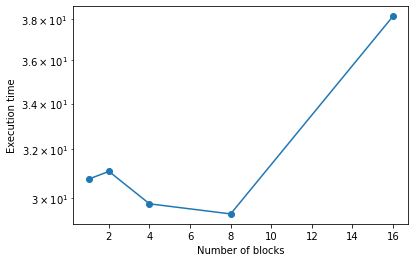

In [8]:
plt.plot(block, execution_time, marker = 'o')
plt.xlabel("Number of blocks")
plt.ylabel("Execution time")

plt.yscale('log')
plt.show()